In [1]:
import ovito
from ovito.io import import_file
from ovito.modifiers import *
from ovito.data import *
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import tarfile

from clusterOVITO.basic.io import *
from clusterOVITO.basic.xyz_to_FEFF import *
from clusterOVITO.ovito_tools import *  
from ovito.modifiers import ReplicateModifier


from clusterOVITO.basic.xyz_to_FEFF import *

rmeshPrime = np.arange(0.01, 6, 0.01)

In [2]:
def make_rdf_feff(distances, rmeshPrime):
    # Use np.histogram to directly compute the count within each bin
    counts, _ = np.histogram(distances, bins=np.append(rmeshPrime, rmeshPrime[-1]+(rmeshPrime[1]-rmeshPrime[0])))
    # Normalize the counts by the width of the bins to get the density
    rdf_normalized = counts / (rmeshPrime[1] - rmeshPrime[0])
    return rdf_normalized

In [3]:
test = {"Pt":1, "C":2, "O":3}
class MD_EXAFS_Binary_Pipeline_General:
    def __init__(self, pipeline, file_params, custom_analysis_func=None):
        self.pipeline = pipeline
        self.framerange = file_params["framerange"]
        self.atoms = file_params["atoms"]
        self.cutoff = file_params["cutoff"]
        self.custom_analysis_func = custom_analysis_func
        self.b_line_table = []

    def run(self):
        for frame in self.framerange:
            self.frame = frame
            data = self.pipeline.compute(frame)
            finder = CutoffNeighborFinder(self.cutoff, data)

            atomic_position_index_list = self.get_atom_indices(data)
            all_positions = data.particles.positions[...]

            if self.custom_analysis_func:
            
                custom_result = self.custom_analysis_func(
                    atomic_position_index_list, finder
                    )
                self.interesting_results = []
                # add metal first
                self.interesting_results.append(all_positions[atomic_position_index_list[0]])
                # add other atoms
                for result in custom_result:
                    self.interesting_results.append(all_positions[result])
            # just add metal
            else:
                self.interesting_results = [all_positions[atomic_position_index_list[0]]]

            self.add_sep_line_start()

            self.make_files()

        self.finish()

    def get_atom_indices(self, data):

        atomic_position_index_list = []
        for atom in self.atoms.values():
            atomic_position_index_list.append(np.where(data.particles['Particle Type'].array == atom)[0])

        return atomic_position_index_list
    

    def make_lattice(self, n_atoms, n_pot, atom_coords):
            n_pots = np.full(n_atoms, n_pot).reshape(-1, 1)
            lattice = np.concatenate((atom_coords, n_pots), axis=1)
            return lattice

    def make_files(self):
        
        n_atoms = [atom.shape[0] for atom in self.interesting_results]
        
        atom_pots = [pot for pot in self.atoms.values()]

        lattices = [self.make_lattice(n_atom, n_pot, atom_coords) for n_atom, n_pot, atom_coords in zip(n_atoms, atom_pots, self.interesting_results)]

        b_line = np.concatenate(lattices, axis=0)
        b_line = np.around(b_line, decimals=4)
        self.b_line_table.append(b_line)


    def add_sep_line_start(self):
        self.b_line_table.append(np.array([[0,0,0,0]]))

    def add_sep_line_end(self):
        self.b_line_table.append(np.array([1,1,1,1]))

    def finish(self):
        self.data = np.concatenate(self.b_line_table, axis=0)


def find_adsorbed_CO(atomic_position_index_list, finder):
        ptatom_index, catom_index, oatom_index = atomic_position_index_list
        interesting_c, interesting_pt, interesting_o = [], [], []
        for i in catom_index:
            neigh = [neigh.index for neigh in finder.find(i)]
            if len(neigh) > 0:
                n_count = 0
                for l in neigh:
                    if l in ptatom_index:
                        n_count += 1
                        interesting_pt.append(l)
                if n_count > 0:
                    interesting_c.append(i)

        interesting_c = np.unique(np.array(interesting_c))
        interesting_pt = np.unique(np.array(interesting_pt))

        for i in interesting_c:
            neigh = [neigh.index for neigh in finder.find(i)]
            if len(neigh) > 0:
                for l in neigh:
                    if l in oatom_index:
                        interesting_o.append(l)

        interesting_o = np.unique(np.array(interesting_o))

        return interesting_c, interesting_o

In [4]:
test = {"Pt":1, "C":2, "O":3}
class MD_EXAFS_Analysis_Pipeline_PtCO:
    def __init__(self, pipeline, file_params, custom_analysis_func=None):
        self.pipeline = pipeline
        self.framerange = file_params["framerange"]
        self.atoms = file_params["atoms"]
        self.cutoff = file_params["cutoff"]
        self.custom_analysis_func = custom_analysis_func
        self.b_line_table = []
        self.n_atoms_list = []

    def run(self):
        for frame in self.framerange:
            self.frame = frame
            data = self.pipeline.compute(frame)
            finder = CutoffNeighborFinder(self.cutoff, data)

            atomic_position_index_list = self.get_atom_indices(data)
            all_positions = data.particles.positions[...]

            if self.custom_analysis_func:
            
                custom_result = self.custom_analysis_func(
                    atomic_position_index_list, finder
                    )
                self.interesting_results = []
                # add metal first
                self.interesting_results.append(all_positions[atomic_position_index_list[0]])
                # add other atoms
                for result in custom_result:
                    self.interesting_results.append(all_positions[result])
            # just add metal
            else:
                self.interesting_results = [all_positions[atomic_position_index_list[0]]]


            self.make_output()

        self.finish()

    def get_atom_indices(self, data):

        atomic_position_index_list = []
        for atom in self.atoms.values():
            atomic_position_index_list.append(np.where(data.particles['Particle Type'].array == atom)[0])

        return atomic_position_index_list
    

    def make_lattice(self, n_atoms, n_pot, atom_coords):
            n_pots = np.full(n_atoms, n_pot).reshape(-1, 1)
            lattice = np.concatenate((atom_coords, n_pots), axis=1)
            return lattice

    def make_output(self):
        
        n_atoms = [atom.shape[0] for atom in self.interesting_results]
        
        atom_pots = [pot for pot in self.atoms.values()]

        lattices = [self.make_lattice(n_atom, n_pot, atom_coords) for n_atom, n_pot, atom_coords in zip(n_atoms, atom_pots, self.interesting_results)]

        b_line = np.concatenate(lattices, axis=0)
        b_line = np.around(b_line, decimals=4)
        self.b_line_table.append(b_line)
        self.n_atoms_list.append(n_atoms)

    def finish(self):
        #self.data = np.concatenate(self.b_line_table, axis=0)
        self.data = self.b_line_table

def find_adsorbed_CO(atomic_position_index_list, finder):
        ptatom_index, catom_index, oatom_index = atomic_position_index_list
        interesting_c, interesting_pt, interesting_o = [], [], []
        for i in catom_index:
            neigh = [neigh.index for neigh in finder.find(i)]
            if len(neigh) > 0:
                n_count = 0
                for l in neigh:
                    if l in ptatom_index:
                        n_count += 1
                        interesting_pt.append(l)
                if n_count > 0:
                    interesting_c.append(i)

        interesting_c = np.unique(np.array(interesting_c))
        interesting_pt = np.unique(np.array(interesting_pt))

        for i in interesting_c:
            neigh = [neigh.index for neigh in finder.find(i)]
            if len(neigh) > 0:
                for l in neigh:
                    if l in oatom_index:
                        interesting_o.append(l)

        interesting_o = np.unique(np.array(interesting_o))

        return interesting_c, interesting_o

In [4]:


###########################################

traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/'
traj_name = "Pt309_cuboct_623K.all.bin"

p_name = "Pt309_cuboct_623K"
#input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
#input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"


###########################################
traj_path = traj_dir + traj_name

pipeline = import_file(traj_path)

test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(14000,16000),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
#test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
test_pl.run()

data = test_pl.data

In [12]:


###########################################

traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/'
traj_name = "Pt309_cuboct_148K.all.bin"

#p_name = "Pt309_cuboct_498K"
#input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
#input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"


###########################################
traj_path = traj_dir + traj_name

pipeline = import_file(traj_path)

test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(14000,16000),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
#test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
test_pl.run()

data = test_pl.data
n_atoms = test_pl.n_atoms_list

In [12]:
len(range(0,16000,100))

160

In [32]:
cluster_dict = {}
#for i in ["148", "298", "398", "498", "623"]:
for i in ["298", "398", "498", "623"]:

    ###########################################

    traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/continued/cubo_147/'
    traj_name = f"Pt147_cuboct_{i}K_4.all.bin"

    #p_name = "Pt309_cuboct_498K"
    #input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
    #input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"

    #pipeline.source.num_frames
    ###########################################
    
    traj_path = traj_dir + traj_name

    pipeline = import_file(traj_path)

    test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(0,pipeline.source.num_frames,100),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
    #test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
    test_pl.run()

    data = test_pl.data
    n_atoms = test_pl.n_atoms_list

    n_atoms = np.array(n_atoms)
    n_co = np.mean(n_atoms[:,1])

    cluster_dict[i] = n_atoms[:,1]


In [12]:
pipeline.source.num_frames

18001

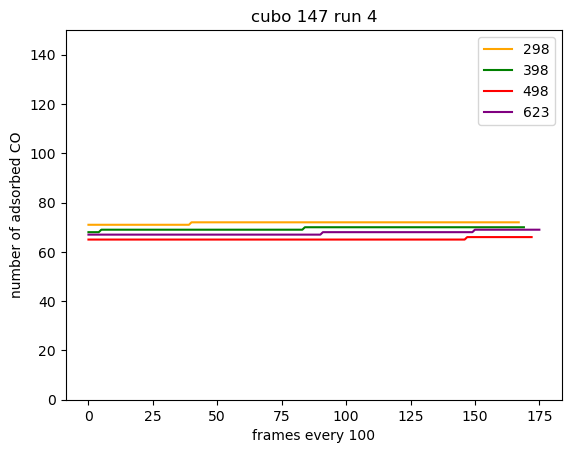

In [33]:
colors = {"148":"blue", "298":"orange","398":"green", "498":"red", "623":"purple"}
#for i in ["148", "298", "398", "498", "623"]:
for i in ["298", "398", "498", "623"]:
    plt.plot(cluster_dict[i], label=i, color=colors[i])
plt.title("cubo 147 run 4")
plt.ylabel("number of adsorbed CO")
plt.xlabel("frames every 100")
plt.ylim(0,150)
plt.legend()

In [6]:
n_atoms = np.array(n_atoms)
n_co = np.mean(n_atoms[:,1])
print(n_co)

60.671


In [13]:
n_atoms = np.array(n_atoms)
n_co = np.mean(n_atoms[:,1])
print(n_co)

40.567


(50.0, 70.0)

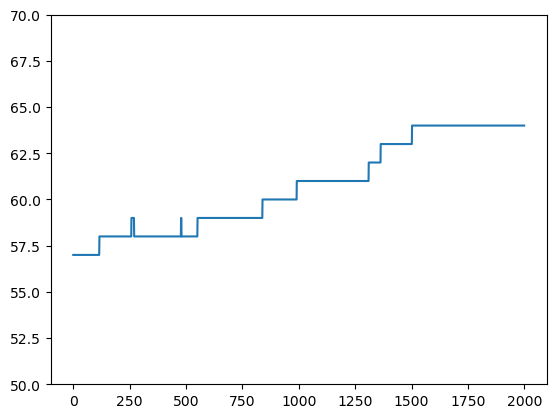

In [11]:
plt.plot(n_atoms[:,1])
plt.ylim(50,70)

(20.0, 70.0)

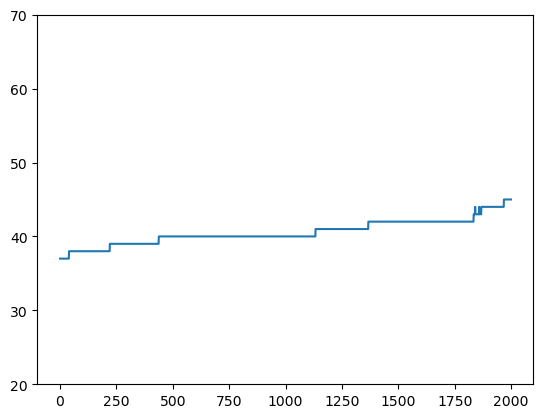

In [15]:
plt.plot(n_atoms[:,1])
plt.ylim(20,70)

In [284]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming 'array_list' is your list of arrays
pt_averages = []
rdf_average = []

for array in data:
    df = pd.DataFrame(array, columns=['x', 'y', 'z', 'p'])
    pt_data = df[df['p'] == 1]
    coords = pt_data[['x', 'y', 'z']]
    distances = pdist(pt_data[['x', 'y', 'z']].values, metric='euclidean')
    distance_matrix = squareform(distances)
    rdfs = np.array([make_rdf_feff(distances, rmeshPrime) for distances in distance_matrix])
    rdf_average.append(np.mean(rdfs, axis=0))
    coords = coords.to_numpy()
    pt_averages.append(coords)

pt_averages = np.array(pt_averages)
pt_average = np.mean(pt_averages, axis=0)
rdf_average = np.array(rdf_average)
rdfs_average = np.mean(rdf_average, axis=0)



In [267]:
rdf_average_623 = rdfs_average

In [274]:
rdf_average_498 = rdfs_average

In [278]:
rdf_average_398 = rdfs_average

In [281]:
rdf_average_298 = rdfs_average

In [285]:
rdf_average_148 = rdfs_average

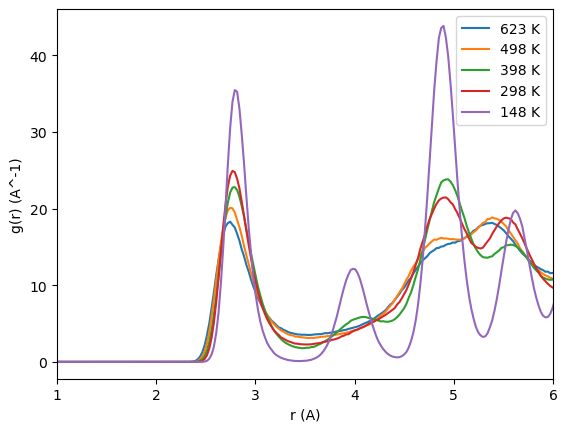

In [287]:
plt.plot(rmeshPrime, rdf_average_623, label="623 K")
plt.plot(rmeshPrime, rdf_average_498, label="498 K")
plt.plot(rmeshPrime, rdf_average_398, label="398 K")
plt.plot(rmeshPrime, rdf_average_298, label="298 K")
plt.plot(rmeshPrime, rdf_average_148, label="148 K")
plt.legend()
plt.xlim(1,6)
plt.xlabel("r (A)")
plt.ylabel("g(r) (A^-1)")
plt.show()


In [264]:
integrate_mono(np.mean(rdf_average, axis=0), rmeshPrime, [2, 3.5])

9.154574433656942

In [126]:
# turn pt_average into a df with the correct column names and make column 4 all 1s
df = pd.DataFrame(pt_average, columns=['x', 'y', 'z'])
df['p'] = 1


In [11]:
np.savetxt( "test_data_309_CO.dat", data[1:], fmt='%1.4f')

In [13]:
import py3Dmol

In [293]:
np.savetxt("/mnt/a/MD_Trajectories/PtCO/NPs/Analysis_output/rdf_cuboct_309_148K.dat", np.column_stack((rmeshPrime,rdf_average_148)), fmt='%1.4f')
np.savetxt("/mnt/a/MD_Trajectories/PtCO/NPs/Analysis_output/rdf_cuboct_309_298K.dat", np.column_stack((rmeshPrime,rdf_average_298)), fmt='%1.4f')
np.savetxt("/mnt/a/MD_Trajectories/PtCO/NPs/Analysis_output/rdf_cuboct_309_398K.dat", np.column_stack((rmeshPrime,rdf_average_398)), fmt='%1.4f')
np.savetxt("/mnt/a/MD_Trajectories/PtCO/NPs/Analysis_output/rdf_cuboct_309_498K.dat", np.column_stack((rmeshPrime,rdf_average_498)), fmt='%1.4f')
np.savetxt("/mnt/a/MD_Trajectories/PtCO/NPs/Analysis_output/rdf_cuboct_309_623K.dat", np.column_stack((rmeshPrime,rdf_average_623)), fmt='%1.4f')

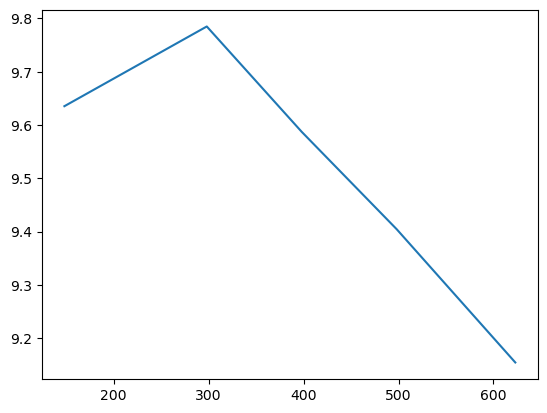

In [294]:
cn_148 = integrate_mono(rdf_average_148, rmeshPrime, [2, 3.5])
cn_298 = integrate_mono(rdf_average_298, rmeshPrime, [2, 3.5])
cn_398 = integrate_mono(rdf_average_398, rmeshPrime, [2, 3.5])
cn_498 = integrate_mono(rdf_average_498, rmeshPrime, [2, 3.5])
cn_623 = integrate_mono(rdf_average_623, rmeshPrime, [2, 3.5])
cns = [cn_148, cn_298, cn_398, cn_498, cn_623]
temps = [148, 298, 398, 498, 623]
plt.plot(temps, cns)

In [297]:
tot_rdf = np.column_stack((rmeshPrime, rdf_average_148))
x,y = np.asarray([l for l in tot_rdf if 2<l[0]<3.5]).transpose()
mean = np.average(x, weights=y)
var = np.average((x - mean)**2, weights=y)
mean_148 = mean
var_148 = var

tot_rdf = np.column_stack((rmeshPrime, rdf_average_298))
x,y = np.asarray([l for l in tot_rdf if 2<l[0]<3.5]).transpose()
mean = np.average(x, weights=y)
var = np.average((x - mean)**2, weights=y)
mean_298 = mean
var_298 = var

tot_rdf = np.column_stack((rmeshPrime, rdf_average_398))
x,y = np.asarray([l for l in tot_rdf if 2<l[0]<3.5]).transpose()
mean = np.average(x, weights=y)
var = np.average((x - mean)**2, weights=y)
mean_398 = mean
var_398 = var

tot_rdf = np.column_stack((rmeshPrime, rdf_average_498))
x,y = np.asarray([l for l in tot_rdf if 2<l[0]<3.5]).transpose()
mean = np.average(x, weights=y)
var = np.average((x - mean)**2, weights=y)
mean_498 = mean
var_498 = var

tot_rdf = np.column_stack((rmeshPrime, rdf_average_623))
x,y = np.asarray([l for l in tot_rdf if 2<l[0]<3.5]).transpose()
mean = np.average(x, weights=y)
var = np.average((x - mean)**2, weights=y)
mean_623 = mean
var_623 = var

means = [mean_148, mean_298, mean_398, mean_498, mean_623]
vars = [var_148, var_298, var_398, var_498, var_623]

In [300]:
means

[2.8308340522732296,
 2.8751596899361695,
 2.8712811611926123,
 2.882869934812169,
 2.8844914758240443]

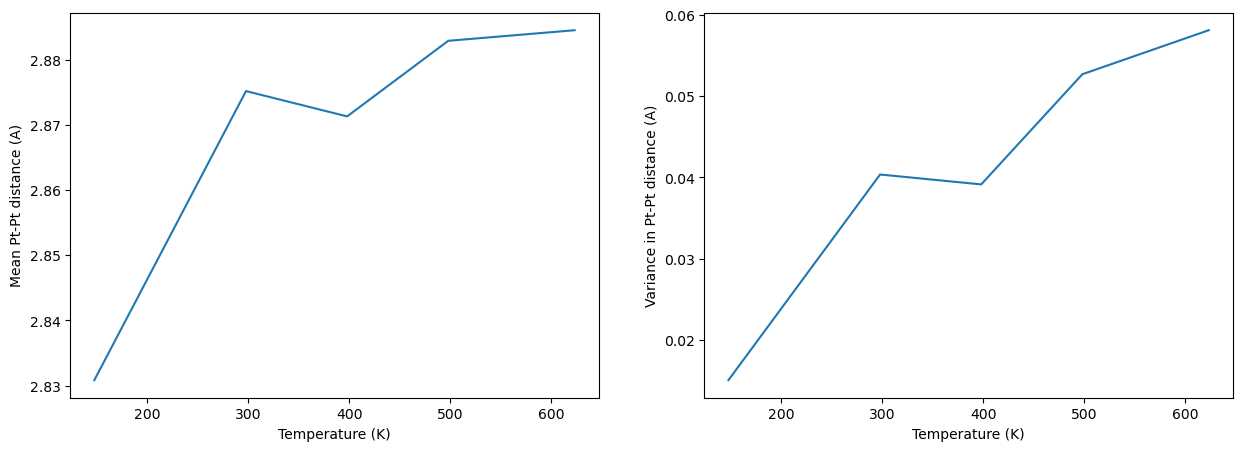

In [313]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.plot(temps, means)
plt.xlabel("Temperature (K)")
plt.ylabel("Mean Pt-Pt distance (A)")


plt.subplot(1,2,2)

plt.plot(temps, vars)
plt.xlabel("Temperature (K)")
plt.ylabel("Variance in Pt-Pt distance (A)")

plt.show()


# Post analysis

In [289]:
from scipy.spatial import cKDTree

import pandas as pd

cutoff_distance = 3.2

# Load the data file
#df = pd.DataFrame(data, columns=['x', 'y', 'z', 'p'])

# Filter out Pt atoms (p = 1)
pt_data = df[df['p'] == 1]

# Using a more efficient method with cKDTree for finding connections
# Convert Pt data to a numpy array for spatial indexing
pt_coords = pt_data[['x', 'y', 'z']].to_numpy()

# Create a KDTree for efficient neighbor search
kd_tree = cKDTree(pt_coords)

# Query the tree for pairs within the cutoff distance
pairs = kd_tree.query_pairs(r=cutoff_distance)

# Convert the pairs set to a list of tuples for easier interpretation
connected_pairs = list(pairs)




In [ ]:
import py3Dmol

def show_connections_3Dmol(atom_index, cutoff_distance=3):
    """
    Visualize the connections of a specified atom in a Jupyter notebook using py3Dmol.

    Parameters:
    atom_index (int): Index of the atom to visualize.
    cutoff_distance (float): Cutoff distance for connections.
    """
    # Find neighbors of the specified atom within the cutoff distance
    neighbors = kd_tree.query_ball_point(pt_coords[atom_index], r=cutoff_distance)

    # Start building the visualization
    view = py3Dmol.view(width=800, height=600)

    # Add atoms to the view
    for i, (x, y, z) in enumerate(pt_coords):
        color = 'blue' if i in neighbors and i != atom_index else 'gray'
        if i == atom_index:
            color = 'red'
        view.addSphere({'center': {'x': x, 'y': y, 'z': z}, 'radius': 0.5, 'color': color})

    # Show the view
    view.zoomTo()
    return view

# Example usage
view = show_connections_3Dmol(5, cutoff_distance=3)
view.show()


In [290]:
import py3Dmol
import numpy as np

def bond_color_gradient(length, min_length, max_length):
    """
    Calculate the color of a bond based on its length using a blue-to-red gradient.

    Parameters:
    length (float): Length of the bond.
    min_length (float): Minimum bond length in the set.
    max_length (float): Maximum bond length in the set.

    Returns:
    str: Hex color code for the bond.
    """
    # Normalize the length to a value between 0 and 1
    normalized_length = (length - min_length) / (max_length - min_length)

    # Calculate red and blue components (green is always 0)
    red = int(normalized_length * 255)
    blue = int((1 - normalized_length) * 255)

    # Convert to hex color code
    return f'#{red:02x}00{blue:02x}'

def show_connections_3Dmol(atom_index, cutoff_distance=3.5, atom_radius=0.3, bond_radius=0.1):
    """
    Visualize the connections of a specified atom in a Jupyter notebook using py3Dmol.
    Colors the bonds based on their length using a blue-to-red gradient.

    Parameters:
    atom_index (int): Index of the atom to visualize.
    cutoff_distance (float): Cutoff distance for connections.
    atom_radius (float): Radius of the atoms for visualization.
    bond_radius (float): Radius of the bonds for visualization.
    """
    # Find neighbors of the specified atom within the cutoff distance
    neighbors = kd_tree.query_ball_point(pt_coords[atom_index], r=cutoff_distance)

    # Calculate bond lengths and find the min and max lengths for coloring
    bond_lengths = [np.linalg.norm(pt_coords[i] - pt_coords[j]) for i, j in connected_pairs]
    #min_length, max_length = min(bond_lengths), max(bond_lengths)
    min_length, max_length = 2, 3.5

    # Start building the visualization
    view = py3Dmol.view(width=800, height=600)

    # Add atoms to the view
    for i, (x, y, z) in enumerate(pt_coords):
        color = 'blue' if i in neighbors and i != atom_index else 'gray'
        if i == atom_index:
            color = 'red'
        view.addSphere({'center': {'x': x, 'y': y, 'z': z}, 'radius': atom_radius, 'color': color})

    # Add bonds and color them based on length
    for i, j in connected_pairs:
        bond_length = np.linalg.norm(pt_coords[i] - pt_coords[j])
        color = bond_color_gradient(bond_length, min_length, max_length)
        view.addCylinder({'start': {'x': pt_coords[i][0], 'y': pt_coords[i][1], 'z': pt_coords[i][2]},
                          'end': {'x': pt_coords[j][0], 'y': pt_coords[j][1], 'z': pt_coords[j][2]},
                          'radius': bond_radius, 'color': color})

    # Show the view
    view.zoomTo()
    return view

# Example usage
view = show_connections_3Dmol(9, cutoff_distance=3.2, atom_radius=0.5, bond_radius=0.3)
view.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [40]:
import py3Dmol
import numpy as np

def bond_color_gradient(length, min_length, max_length):
    """
    Calculate the color of a bond based on its length using a blue-to-red gradient.
    """
    normalized_length = (length - min_length) / (max_length - min_length)
    red = int(normalized_length * 255)
    blue = int((1 - normalized_length) * 255)
    return f'#{red:02x}00{blue:02x}'

def show_connections_3Dmol_with_slice(atom_index, cutoff_distance=3.5, atom_radius=0.3, bond_radius=0.1, slice_point=None, slice_normal=None):
    """
    Visualize the connections of a specified atom in a Jupyter notebook using py3Dmol, with cross-section slicing.
    """
    bond_lengths = [np.linalg.norm(pt_coords[i] - pt_coords[j]) for i, j in connected_pairs]
    min_length, max_length = min(bond_lengths), max(bond_lengths)

    def is_visible(point):
        if slice_point is None or slice_normal is None:
            return True
        return np.dot(point - slice_point, slice_normal) <= 0

    view = py3Dmol.view(width=800, height=600)

    # Define a point on the slicing plane (e.g., the centroid of the particle)
    if slice_point is None and slice_normal is not None:
        slice_point = np.mean(pt_coords, axis=0)

    for i, (x, y, z) in enumerate(pt_coords):
        if is_visible(np.array([x, y, z])):
            color = 'blue' if i in kd_tree.query_ball_point(pt_coords[atom_index], r=cutoff_distance) else 'gray'
            if i == atom_index:
                color = 'red'
            view.addSphere({'center': {'x': x, 'y': y, 'z': z}, 'radius': atom_radius, 'color': color})

    for i, j in connected_pairs:
        if is_visible(pt_coords[i]) and is_visible(pt_coords[j]):
            bond_length = np.linalg.norm(pt_coords[i] - pt_coords[j])
            color = bond_color_gradient(bond_length, min_length, max_length)
            view.addCylinder({'start': {'x': pt_coords[i][0], 'y': pt_coords[i][1], 'z': pt_coords[i][2]},
                              'end': {'x': pt_coords[j][0], 'y': pt_coords[j][1], 'z': pt_coords[j][2]},
                              'radius': bond_radius, 'color': color})

    view.zoomTo()
    return view

# Example usage
# Define a slicing plane normal to the Z-axis at the center of the particle
center_point = np.mean(pt_coords, axis=0)
normal_vector = [0, 0, 1]
view = show_connections_3Dmol_with_slice(5, cutoff_distance=3.5, atom_radius=0.5, bond_radius=0.5, slice_point=center_point, slice_normal=normal_vector)
view.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Just RDFS

In [191]:
from ovito.io import import_file
from ovito.data import CutoffNeighborFinder
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from xrayFLARE.basic.io import *
from xrayFLARE.ovito_tools.ovito_tools import make_rdf_feff, integrate_mono

rmeshPrime = np.linspace(.01, 7, 300)

def make_rdf_feff(distances, rmeshPrime):
    # Use np.histogram to directly compute the count within each bin
    counts, _ = np.histogram(distances, bins=np.append(rmeshPrime, rmeshPrime[-1]+(rmeshPrime[1]-rmeshPrime[0])))
    # Normalize the counts by the width of the bins to get the density
    rdf_normalized = counts / (rmeshPrime[1] - rmeshPrime[0])
    return rdf_normalized


class ParameterAnalysisPipeline:
    def __init__(self, file_path, framerange, step=1, rdf_mode=False):
        self.pipeline = import_file(file_path)
        self.framerange = framerange[::step]
        self.step = step
        self.rdf_mode = rdf_mode
        self.atoms = {"Pt":1, "C":2, "O":3}

        if self.rdf_mode:
            self.results = {
                "rdf": {}
            }
        else:
            self.results = {
                "cn": {},
                "variances": {},
                "means": {}
            }

    def run(self):
        
        if self.rdf_mode:
            for frame in self.framerange:
                data = self.pipeline.compute(frame)
                finder = CutoffNeighborFinder(7, data)  # Adjust the cutoff distance as needed

                rdf = self.compute_AuAu_metrics(data, finder)
                
                self.update_results(frame, rdf=rdf)

            self.process_results()

        else:
            for frame in self.framerange:
                data = self.pipeline.compute(frame)
                finder = CutoffNeighborFinder(7, data)  # Adjust the cutoff distance as needed

                cns, variances, means = self.compute_AuAu_metrics(data, finder)
                
                self.update_results(frame, cns=cns, variances=variances, means=means)

            self.process_results()

    def compute_AuAu_metrics(self, data, finder):
        au_au_dist = []

        atomic_position_index_list = self.get_atom_indices(data)
        ptatom_index, catom_index, oatom_index = atomic_position_index_list
        
        for i in ptatom_index:
            rs = [neigh.distance for neigh in finder.find(i)]
            rdf = make_rdf_feff(rs, rmeshPrime)
            au_au_dist.append(rdf)
        
        au_au_dist = np.array(au_au_dist)
        ave_rdf = np.mean(au_au_dist, axis=0)

        if self.rdf_mode:
            return ave_rdf
        else:
            grid_rdf = np.array([rmeshPrime, ave_rdf]).transpose()
            peaks, properties = find_peaks(ave_rdf, prominence=1, width=2.8)

            neg_peaks, neg_properties = find_peaks(-ave_rdf, prominence=1, distance=20, width=2.8)

            end_points = neg_peaks
            start_points = np.insert(neg_peaks[1:3], 0, 90) # 90 is around 2 A

            peaks = peaks[:4]

            ranges = ((rmeshPrime[start_points[0]], rmeshPrime[end_points[0]]),
            (rmeshPrime[end_points[0]], rmeshPrime[start_points[1]]),
            (rmeshPrime[end_points[1]], rmeshPrime[end_points[2]]),
            (rmeshPrime[end_points[2]], rmeshPrime[end_points[3]]))

            variances = []
            means = []
            cns = []
        
            for item in ranges:
                cns.append(integrate_mono(ave_rdf, rmeshPrime, item))
                x,y = np.asarray([l for l in grid_rdf if item[0]<l[0]<item[1]]).transpose()
                mean = np.average(x, weights=y)
                v = np.average((x - mean)**2, weights=y)
                variances.append(v)
                means.append(mean)

            return cns, variances, means
    
    def update_results(self, frame, cns=None, variances=None, means=None, rdf=None):
        if self.rdf_mode:
            if rdf is not None:
                self.results["rdf"][frame] = rdf
            else:
                raise ValueError("rdf must be provided in rdf_mode")
        else:
            if cns is None or variances is None or means is None:
                raise ValueError("cns, variances, and means must be provided when not in rdf_mode")
            self.results["cn"][frame] = cns
            self.results["variances"][frame] = variances
            self.results["means"][frame] = means

    def process_results(self):
        for key in self.results.keys():
            self.results[key] = np.array(list(self.results[key].values()))

    def get_atom_indices(self, data):

        atomic_position_index_list = []
        for atom in self.atoms.values():
            atomic_position_index_list.append(np.where(data.particles['Particle Type'].array == atom)[0])

        return atomic_position_index_list

In [140]:
traj_path

'/mnt/a/MD_Trajectories/PtCO/NPs/Pt309_cuboct_623K.all.bin'

In [197]:
traj_name = "Pt309_cuboct_623K.all.bin"
traj_path = traj_dir + traj_name
pipeline = ParameterAnalysisPipeline(traj_path, range(14000,16000), rdf_mode=True)
pipeline.run()
rdf_623 = np.mean(pipeline.results["rdf"], axis=0)

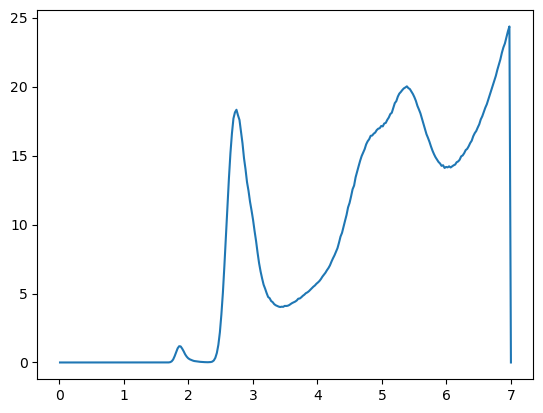

In [198]:
plt.plot(rmeshPrime, rdf_623)

In [193]:
traj_name = "Pt309_cuboct_148K.all.bin"
traj_path = traj_dir + traj_name
pipeline = ParameterAnalysisPipeline(traj_path, range(14000,16000), rdf_mode=True)
pipeline.run()
rdf_148 = np.mean(pipeline.results["rdf"], axis=0)

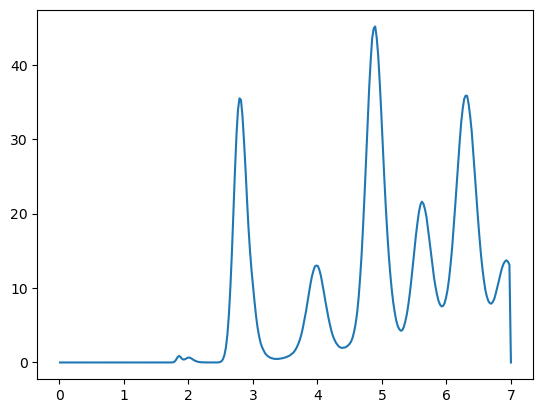

In [194]:
plt.plot(rmeshPrime, rdf_148)

In [153]:
traj_name = "Pt309_cuboct_298K.all.bin"
traj_path = traj_dir + traj_name
pipeline = ParameterAnalysisPipeline(traj_path, range(14000,16000), rdf_mode=True)
pipeline.run()
rdf_298 = np.mean(pipeline.results["rdf"], axis=0)

In [154]:
traj_name = "Pt309_cuboct_398K.all.bin"
traj_path = traj_dir + traj_name
pipeline = ParameterAnalysisPipeline(traj_path, range(14000,16000), rdf_mode=True)
pipeline.run()
rdf_398 = np.mean(pipeline.results["rdf"], axis=0)

In [155]:
traj_name = "Pt309_cuboct_498K.all.bin"
traj_path = traj_dir + traj_name
pipeline = ParameterAnalysisPipeline(traj_path, range(14000,16000), rdf_mode=True)
pipeline.run()
rdf_498 = np.mean(pipeline.results["rdf"], axis=0)

In [146]:
rdf_623 = np.mean(pipeline.results["rdf"], axis=0)

(1.0, 6.0)

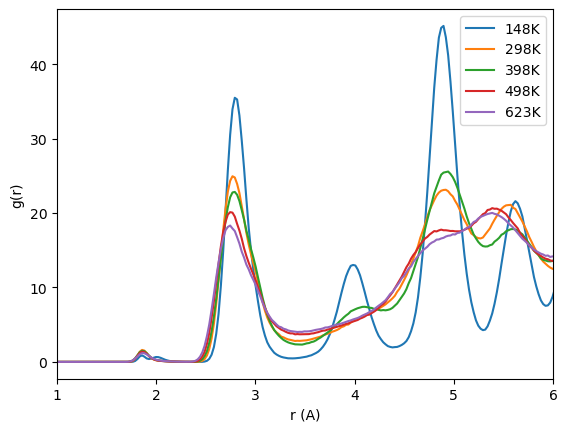

In [204]:
plt.plot(rmeshPrime, rdf_148, label="148K")
plt.plot(rmeshPrime, rdf_298, label="298K")
plt.plot(rmeshPrime, rdf_398, label="398K")
plt.plot(rmeshPrime, rdf_498, label="498K")
plt.plot(rmeshPrime, rdf_623, label="623K")
plt.legend()
plt.xlabel("r (A)")
plt.ylabel("g(r)")
plt.xlim(1,6)

In [205]:
integrate_mono(rdf_148, rmeshPrime, (2.5, 3.5))

9.907746763754034